In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

2024-10-10 16:34:53.826275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 16:34:53.889394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 16:34:53.892835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 16:34:53.957348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 16:34:54.973426: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1728538496.237772   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538497.172920   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538497.175012   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")

data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,1,-0.847627,-0.516768,-0.887673,1,0.010022,0.618786,1.632356,0.090399,0,6,2
1,1,-0.847627,-0.516768,-0.887673,2,-0.019491,0.672789,1.613112,0.078000,0,6,2
2,1,-0.847627,-0.516768,-0.887673,3,-0.035476,0.618856,1.575681,0.075098,0,6,2
3,1,-0.847627,-0.516768,-0.887673,4,-0.085177,0.598500,1.568844,0.063920,0,6,2
4,1,-0.847627,-0.516768,-0.887673,5,-0.108754,0.759250,1.580504,0.050930,0,6,2


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1728538498.744461   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538498.746664   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538498.749202   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538498.849791   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
# variances = data.var()
# print(variances)

# low_variance_cols = variances[variances < 5e-3].index.tolist()
# print("Columns with low or zero variance:")
# print(low_variance_cols)

In [8]:
# # Drop constant columns and timeframe from the DataFrame
# data.drop(low_variance_cols, axis=1, inplace=True)
# data.drop(['csi_len', 'rate', 'payload_length', 'block_length'], axis=1, inplace=True)
# data.drop('timestamps', axis=1, inplace=True)
# data.head()

In [9]:
# # features_to_scale = ['csi_len', 'payload_length', 'block_length', 'ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
# features_to_scale = ['ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
features_to_scale = ['ant1_amplitude', 'ant2_amplitude']
scaler = StandardScaler()

# Apply standardization on features
# data = data_cleaned.copy()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,1,-0.847627,-0.516768,-0.887673,1,0.010022,0.618786,1.632356,0.090399,0,6,2
1,1,-0.847627,-0.516768,-0.887673,2,-0.019491,0.672789,1.613112,0.078000,0,6,2
2,1,-0.847627,-0.516768,-0.887673,3,-0.035476,0.618856,1.575681,0.075098,0,6,2
3,1,-0.847627,-0.516768,-0.887673,4,-0.085177,0.598500,1.568844,0.063920,0,6,2
4,1,-0.847627,-0.516768,-0.887673,5,-0.108754,0.759250,1.580504,0.050930,0,6,2


In [10]:
# # Step 1: Extract your data (using the amplitude data as an example)
# X = data[['ant1_amplitude', 'ant2_amplitude']].values

# # Step 2: Use Nearest Neighbors to find the k nearest neighbors
# k = 49  # min_samples - 1 for DBSCAN, for example, min_samples = 5, so k = 4
# neighbors = NearestNeighbors(n_neighbors=k)
# neighbors_fit = neighbors.fit(X)
# distances, indices = neighbors_fit.kneighbors(X)

# # Step 3: Sort the distances to the k-th nearest neighbor
# # The distance to the k-th nearest neighbor is in the last column (index k-1)
# k_distances = distances[:, k-1]
# k_distances = np.sort(k_distances)

# # Step 4: Plot the sorted k-distance graph
# plt.figure(figsize=(8, 5))
# plt.plot(k_distances)
# plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
# plt.ylabel('{}-th nearest neighbor distance'.format(k))
# plt.title('K-Distance Graph (Elbow Method for DBSCAN)')
# plt.grid(True)
# plt.show()

In [11]:
# amplitudes = data[['ant1_amplitude', 'ant2_amplitude']].values

In [12]:
# dbscan = hdbscan.HDBSCAN(min_samples=10, core_dist_n_jobs=-1)

In [13]:
# dbscan = DBSCAN(eps=0.1, min_samples=50)

In [14]:
# data_sample = data.sample(frac=0.1)
# amplitudes = data_sample[['ant1_amplitude', 'ant2_amplitude']].values

In [15]:
# dbscan.fit(amplitudes)

In [16]:
# # Step 4: Add the cluster labels to the dataframe
# data['cluster'] = dbscan.labels_

# data.head()

# # Step 5: Visualize the clusters
# plt.scatter(data['ant1_amplitude'], data['ant2_amplitude'], c=data['cluster'], cmap='viridis', alpha=0.6)
# plt.xlabel('Ant1 Amplitude')
# plt.ylabel('Ant2 Amplitude')
# plt.title('DBSCAN Clustering on Amplitude Data')
# plt.colorbar(label='Cluster Label')
# plt.show()

In [17]:
data.drop('with_receiver', axis=1, inplace=True)

In [18]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,coord1,coord2,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,1,-0.847627,-0.516768,-0.887673,0.010022,0.618786,1.632356,0.090399,6,2,...,False,False,False,False,False,False,False,False,False,False
1,1,-0.847627,-0.516768,-0.887673,-0.019491,0.672789,1.613112,0.078000,6,2,...,False,False,False,False,False,False,False,False,False,False
2,1,-0.847627,-0.516768,-0.887673,-0.035476,0.618856,1.575681,0.075098,6,2,...,False,False,False,False,False,False,False,False,False,False
3,1,-0.847627,-0.516768,-0.887673,-0.085177,0.598500,1.568844,0.063920,6,2,...,False,False,False,False,False,False,False,False,False,False
4,1,-0.847627,-0.516768,-0.887673,-0.108754,0.759250,1.580504,0.050930,6,2,...,False,False,False,False,False,False,False,False,False,False


# Model

In [19]:
model_type = "dnn"

In [20]:
X = data.drop(columns=['coord1', 'coord2']) 
y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [21]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [22]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [23]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [24]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (861873, 64)
Validation set shape: (287291, 64)
Test set shape: (287292, 64)


In [25]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1728538499.634279   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538499.635595   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728538499.636791   14147 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,323,922 (43.20 MB)

 Trainable params: 11,323,922 (43.20 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=30, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    # Evaluate the model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/30


2024-10-10 16:40:40.132433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 16 bytes spill stores, 16 bytes spill loads

2024-10-10 16:40:40.171003: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 344 bytes spill stores, 292 bytes spill loads

2024-10-10 16:40:40.306413: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_433', 132 bytes spill stores, 132 bytes spill loads

2024-10-10 16:40:40.483106: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_433', 344 bytes spill stores, 292 bytes spill loads

2024-10-10 16:40:40.786137: I external/local_xla/xla/strea

6727/6734 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5602 - mae: 0.4215

2024-10-10 16:41:10.256220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 20 bytes spill stores, 20 bytes spill loads

2024-10-10 16:41:10.386994: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 204 bytes spill stores, 204 bytes spill loads

2024-10-10 16:41:10.674357: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_447', 412 bytes spill stores, 436 bytes spill loads

2024-10-10 16:41:10.946272: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_433', 20 bytes spill stores, 20 bytes spill loads

2024-10-10 16:41:11.199827: I external/local_xla/xla/stream_

6734/6734 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.5601 - mae: 0.4214 - val_loss: 0.5045 - val_mae: 0.3872
Epoch 2/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.4449 - mae: 0.3563 - val_loss: 0.4274 - val_mae: 0.3324
Epoch 3/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.3861 - mae: 0.3209 - val_loss: 0.3241 - val_mae: 0.2821
Epoch 4/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.3592 - mae: 0.3039 - val_loss: 0.4326 - val_mae: 0.3521
Epoch 5/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.3354 - mae: 0.2892 - val_loss: 0.3121 - val_mae: 0.2651
Epoch 6/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2982 - mae: 0.2652 - val_loss: 0.2753 - val_mae: 0.2515
Epoch 7/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2905 - mae: 0.2583 - val_loss: 0.2780 - val_mae: 0.2536
Epoch 8/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2725 - mae: 0.2469 - val_loss: 0.2683 - val_mae: 0.2371
Epoch 9/30
6734/6734 ━━━━━━━━━━━━━━━━━━━━ 2

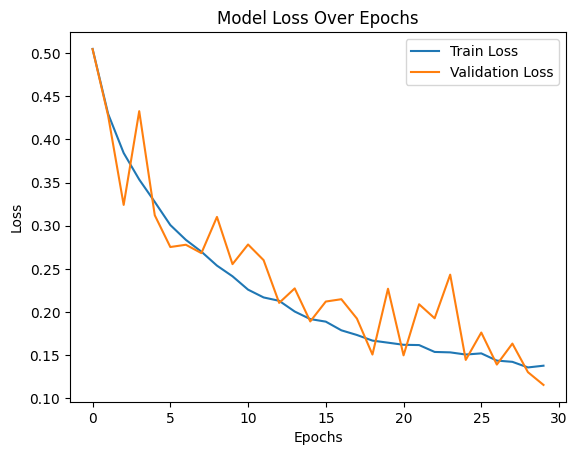

In [43]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [44]:
# After training your model
y_pred = model.predict(X_test)

8978/8978 ━━━━━━━━━━━━━━━━━━━━ 6s 636us/step


In [45]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [46]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.0233
Mean Relative Error for coord2: 0.0237


In [47]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.9724
Spearman's Rank Correlation for coord2: 0.9610


In [48]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [49]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [50]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [51]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.0392


In [52]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9647
Accuracy within tolerance 0.5: 0.9185
Accuracy within tolerance 0.1: 0.6499


In [53]:
tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

y_pred_np_rounded = np.round(y_pred_np)

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np_rounded, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9803
Accuracy within tolerance 0.5: 0.9185
Accuracy within tolerance 0.1: 0.9185


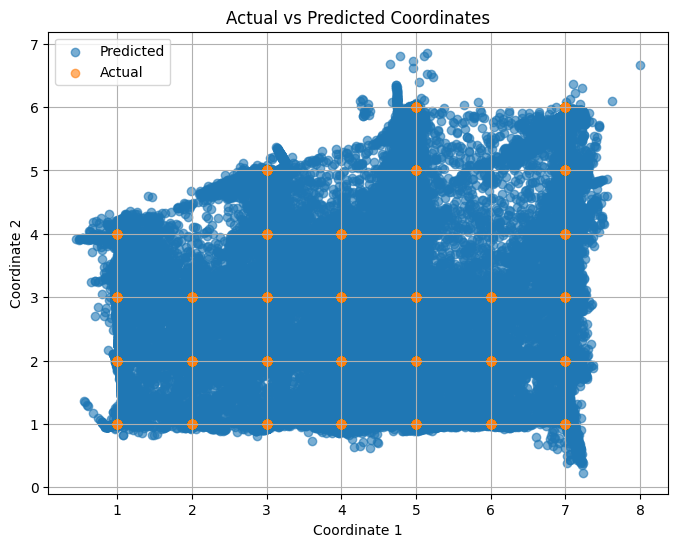

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

MAE for coord1: 0.1397
MAE for coord2: 0.1184
Overall MAE: 0.1290
RMSE for coord1: 0.3780
RMSE for coord2: 0.3043
Overall RMSE: 0.3412
Mean Euclidean Distance Error: 0.2042 units
R-squared for coord1: 0.9631
R-squared for coord2: 0.9585
Median Absolute Error for coord1: 0.0538
Median Absolute Error for coord2: 0.0430
Accuracy within tolerance 1: 0.9647
Accuracy within tolerance 0.5: 0.9185
Accuracy within tolerance 0.1: 0.6499


In [56]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# def mean_euclidean_error(y_true, y_pred):
#     return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

# # Create a scorer based on your custom metric
# scorer = make_scorer(mean_euclidean_error, greater_is_better=False)

# # Assuming you have a model compatible with scikit-learn's API
# scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
# print(f"Cross-validated Mean Euclidean Distance Error: {-np.mean(scores):.4f}")


In [57]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")
accuracy = custom_accuracy(y_test_np, y_pred_np, 1)
model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")

In [59]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    # Create and train the model
    model = create_dnn_model(input_shape=(X_train_cv.shape[1],))
    model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=128, verbose=0)
    
    # Evaluate the model
    y_pred_cv = model.predict(X_test_cv)
    mae_cv = np.mean(np.abs(y_test_cv - y_pred_cv))
    mae_scores.append(mae_cv)

print(f"Cross-validated MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

KeyError: "None of [Index([      0,       1,       2,       3,       4,       6,       7,       8,\n             9,      10,\n       ...\n       1436445, 1436446, 1436447, 1436448, 1436449, 1436450, 1436451, 1436452,\n       1436454, 1436455],\n      dtype='int64', length=1149164)] are in the [columns]"

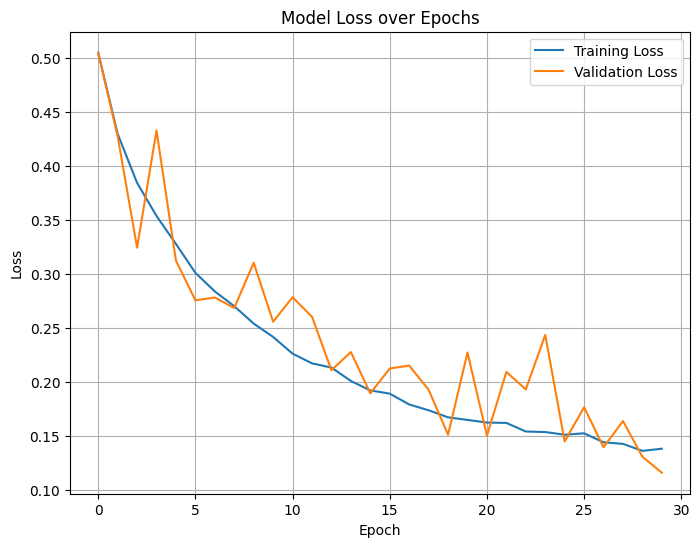

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
